# Imports

In [9]:
import time
import copy
import torch
import pathlib
import random

import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from tqdm.auto import tqdm
from IPython.display import HTML
from torchvision import transforms
from torchvision.datasets import ImageFolder

import requests, os
from zipfile import ZipFile
from IPython.display import clear_output

# Helper functions

In [5]:
print("Start downloading and unzipping `AnimalFaces` dataset...")
name = 'afhq'
fname = f"{name}.zip"
url = f"https://osf.io/kgfvj/download"

if not os.path.exists(fname):
    r = requests.get(url, allow_redirects=True)
    with open(fname, 'wb') as fh:
        fh.write(r.content)

    if os.path.exists(fname):
        with ZipFile(fname, 'r') as zfile:
            zfile.extractall(f".")
            os.remove(fname)

print("Download completed.")

Start downloading and unzipping `AnimalFaces` dataset...
Download completed.


In [7]:
print("Start downloading and unzipping `Randomized AnimalFaces` dataset...")

names = ['afhq_random_32x32', 'afhq_10_32x32']
urls = ["https://osf.io/9sj7p/download",
        "https://osf.io/wvgkq/download"]

for i, name in enumerate(names):
    url = urls[i]
    fname = f"{name}.zip"

    if not os.path.exists(fname):
        r = requests.get(url, allow_redirects=True)
        with open(fname, 'wb') as fh:
            fh.write(r.content)

    if os.path.exists(fname):
        with ZipFile(fname, 'r') as zfile:
            zfile.extractall(f".")
            os.remove(fname)

print("Download completed.")

Start downloading and unzipping `Randomized AnimalFaces` dataset...
Download completed.


In [8]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis(False)
    plt.show()

def plot_weights(norm, labels, ws, title='Weight Size Measurement'):
    plt.figure(figsize=[8, 6])
    plt.title(title)
    plt.ylabel('Frobenius Norm Value')
    plt.xlabel('Model Layers')
    plt.bar(labels, ws)
    plt.axhline(y=norm,
              linewidth=1,
              color='r',
              ls='--',
              label='Total Model F-Norm')
    plt.legend()
    plt.show()


def early_stop_plot(train_acc_earlystop, val_acc_earlystop, best_epoch):
    plt.figure(figsize=(8, 6))
    plt.plot(val_acc_earlystop,label='Val - Early',c='red',ls = 'dashed')
    plt.plot(train_acc_earlystop,label='Train - Early',c='red',ls = 'solid')
    plt.axvline(x=best_epoch, c='green', ls='dashed',
              label='Epoch for Max Val Accuracy')
    plt.title('Early Stopping')
    plt.ylabel('Accuracy (%)')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

In [10]:
def set_seed(seed=None, seed_torch=True):
    if seed is None:
        seed = np.random.choice(2 ** 32)
    random.seed(seed)
    np.random.seed(seed)
    if seed_torch:
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

    print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [11]:
def set_device():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    return device

In [12]:
SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2021 has been set.


In [13]:
# Network Class - Animal Faces
class AnimalNet(nn.Module):
    def __init__(self):
        super(AnimalNet, self).__init__()
        self.fc1 = nn.Linear(3 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 3)

    def forward(self, x):
        x = x.view(x.shape[0],-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output

In [14]:
def train(args, model, train_loader, optimizer,
          reg_function1=None, reg_function2=None, criterion=F.nll_loss):
    """
    Trains the current inpur model using the data
    from Train_loader and Updates parameters for a single pass
    """
    device = args['device']
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        if reg_function1 is None:
            loss = criterion(output, target)
        elif reg_function2 is None:
            loss = criterion(output, target)+args['lambda']*reg_function1(model)
        else:
            loss = criterion(output, target) + args['lambda1']*reg_function1(model) + args['lambda2']*reg_function2(model)
        loss.backward()
        optimizer.step()

    return model


def test(model, test_loader, criterion=F.nll_loss, device='cpu'):
    """
    Tests the current Model
    """
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    return 100. * correct / len(test_loader.dataset)


def main(args, model, train_loader, val_loader,
         reg_function1=None, reg_function2=None):
    """
    Trains the model with train_loader and tests the learned model using val_loader
    """

    device = args['device']

    model = model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=args['lr'],
                        momentum=args['momentum'])

    val_acc_list, train_acc_list,param_norm_list = [], [], []
    for epoch in tqdm(range(args['epochs'])):
        trained_model = train(args, model, train_loader, optimizer,
                              reg_function1=reg_function1,
                              reg_function2=reg_function2)
        train_acc = test(trained_model, train_loader, device=device)
        val_acc = test(trained_model, val_loader, device=device)
        param_norm = calculate_frobenius_norm(trained_model)
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        param_norm_list.append(param_norm)

    return val_acc_list, train_acc_list, param_norm_list, trained_model

# Regularization is Shrinkage

One way to think about Regularization is to think in terms of the magnitude of the overall weights of the model. A model with big weights can fit more data perfectly, whereas a model with smaller weights tends to underperform on the train set but can surprisingly do very well on the test set. Having the weights too small can also be an issue as it can then underfit the model.

This week we use the sum of Frobenius Norm of all the tensors in the model as a measure of the "size of the model".

Before we start, let's define the Frobenius norm, sometimes also called the Euclidean norm of an $m×n$ matrix $A$  as the square root of the sum of the absolute squares of its elements.

<br>

\begin{equation}
||A||_F= \sqrt{\sum_{i=1}^m\sum_{j=1}^n|a_{ij}|^2}
\end{equation} 

This is just a measure of how big the matrix is, analogous to how big a vector is.

Random seed 2021 has been set.
Frobenius Norm of Single Linear Layer: 0.6572


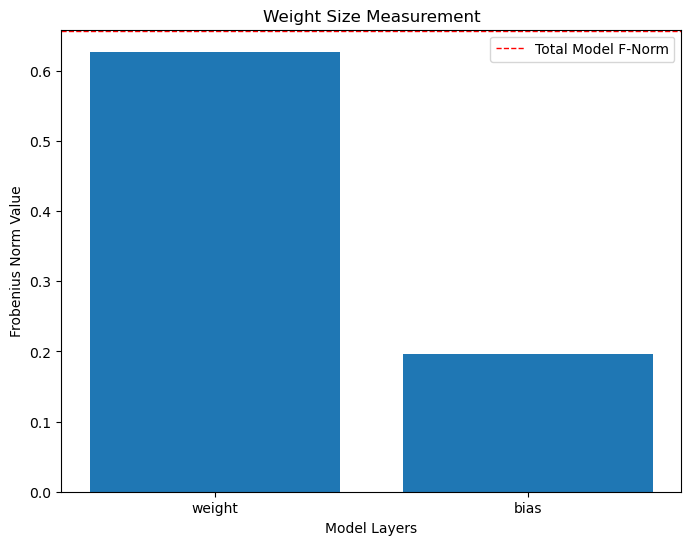

In [16]:
# Frobenius Norm per Layer
def calculate_frobenius_norm(model):

    # initialization of variables
    norm, ws, labels = 0.0, [], []

    # Sum all the parameters
    for name, parameters in model.named_parameters():
        p = torch.sum(parameters**2)
        norm += p

        ws.append((p**0.5).cpu().detach().numpy())
        labels.append(name)

    # Take a square root of the sum of squares of all the parameters
    norm = (norm**0.5).cpu().detach().numpy()

    return norm, ws, labels


set_seed(SEED)
net = nn.Linear(10,1)
norm, ws, labels = calculate_frobenius_norm(net)
print(f'Frobenius Norm of Single Linear Layer: {norm:.4f}')
# Plots the weights
plot_weights(norm, labels, ws)

Random seed 2021 has been set.
Frobenius Norm of Models weights: 7.3810


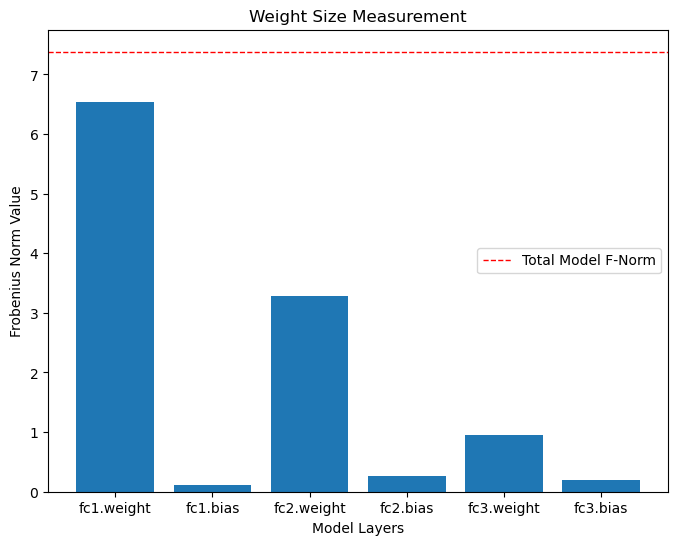

In [17]:
set_seed(seed=SEED)

# Creates a new model
model = AnimalNet()

# Calculates the forbenius norm per layer
norm, ws, labels = calculate_frobenius_norm(model)
print(f'Frobenius Norm of Models weights: {norm:.4f}')

# Plots the weights
plot_weights(norm, labels, ws)

# Overfitting

## Visualizing overfitting

Random seed 2021 has been set.


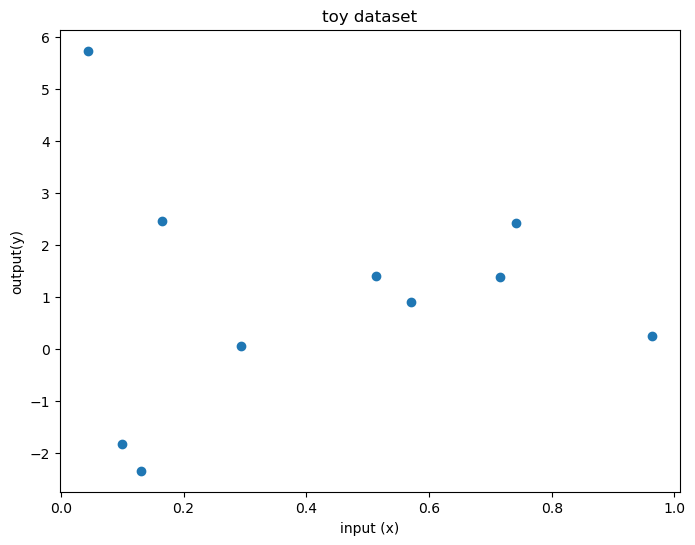

In [18]:
set_seed(seed=SEED)

# creating train data
# input
X = torch.rand((10, 1))
# output
Y = 2*X + 2*torch.empty((X.shape[0], 1)).normal_(mean=0, std=1)  # adding small error in the data

#visualizing trian data
plt.figure(figsize=(8, 6))
plt.scatter(X.numpy(),Y.numpy())
plt.xlabel('input (x)')
plt.ylabel('output(y)')
plt.title('toy dataset')
plt.show()

#creating test dataset
X_test = torch.linspace(0, 1, 40)
X_test = X_test.reshape((40, 1, 1))

In [19]:
# Network Class - 2D
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(1, 300)
        self.fc2 = nn.Linear(300, 500)
        self.fc3 = nn.Linear(500, 1)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        output = self.fc3(x)
        return output

In [20]:
set_seed(seed=SEED)

# train the network on toy dataset
model = Net()

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

iters = 0
# Calculates frobenius before training
normi, wsi, label = calculate_frobenius_norm(model)

Random seed 2021 has been set.


In [21]:
set_seed(seed=SEED)
# initializing variables

# losses
train_loss = []
test_loss = []
# model norm
model_norm = []
# Initializing variables to store weights
norm_per_layer = []

max_epochs = 10000

running_predictions = np.empty((40, int(max_epochs / 500 + 1)))

for epoch in tqdm(range(max_epochs)):
    # frobenius norm per epoch
    norm, pl, layer_names = calculate_frobenius_norm(model)

    # training
    model_norm.append(norm)
    norm_per_layer.append(pl)
    model.train()
    optimizer.zero_grad()
    predictions = model(X)
    loss = criterion(predictions, Y)
    loss.backward()
    optimizer.step()

    train_loss.append(loss.data)
    model.eval()
    Y_test = model(X_test)
    loss = criterion(Y_test, 2*X_test)
    test_loss.append(loss.data)

    if (epoch % 500 == 0 or epoch == max_epochs - 1):
        running_predictions[:, iters] = Y_test[:, 0, 0].detach().numpy()
        iters += 1

Random seed 2021 has been set.


  0%|          | 0/10000 [00:00<?, ?it/s]

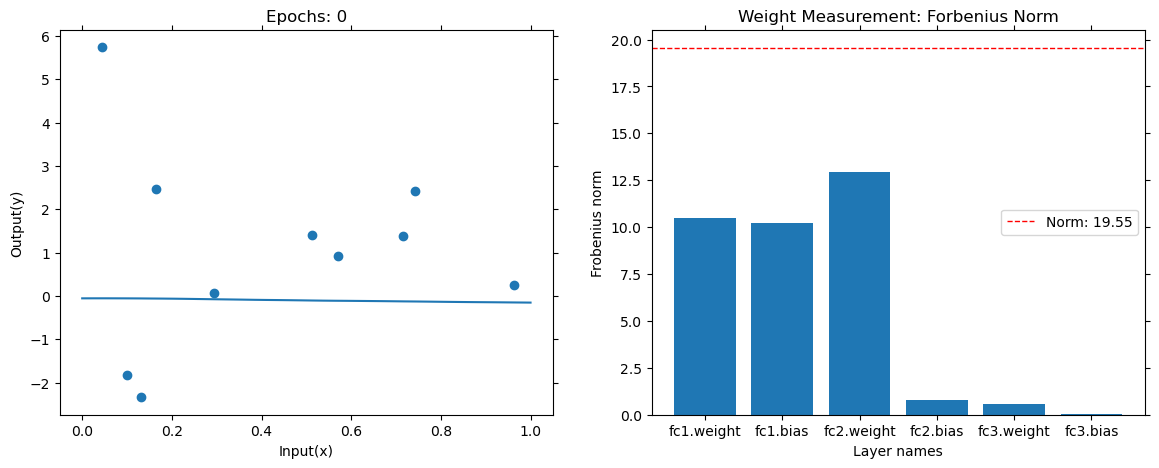

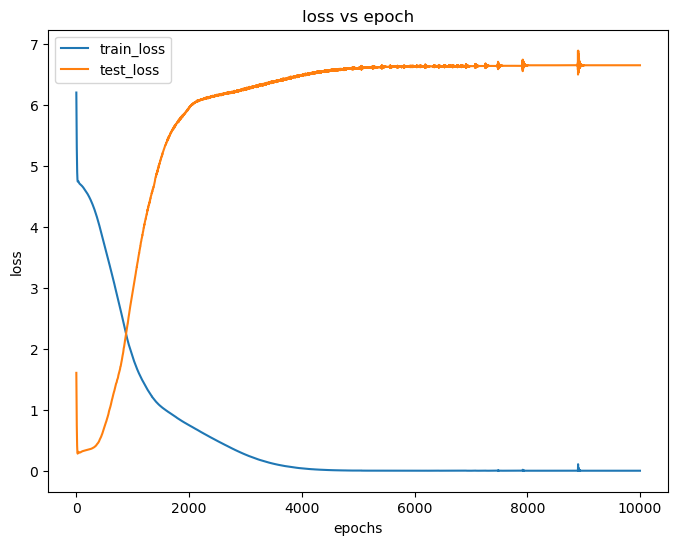

In [23]:
plt.figure(figsize=(8, 6))
plt.plot(train_loss,label='train_loss')
plt.plot(test_loss,label='test_loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.title('loss vs epoch')
plt.legend()
plt.show()

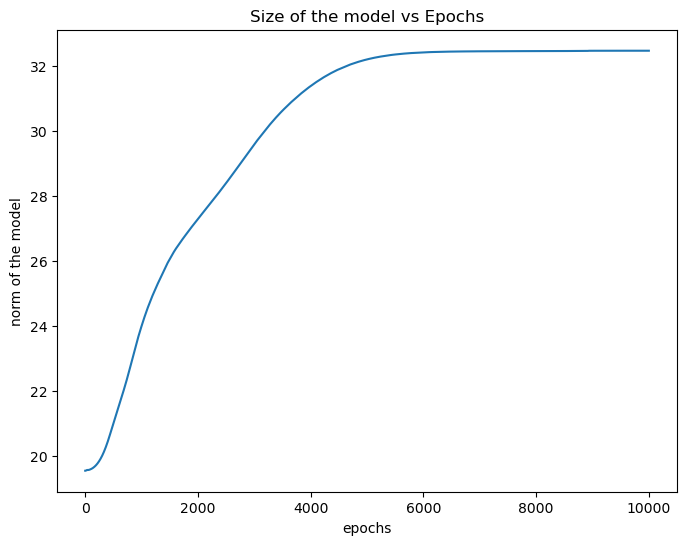

In [24]:
plt.figure(figsize=(8, 6))
plt.plot(model_norm)
plt.ylabel('norm of the model')
plt.xlabel('epochs')
plt.title('Size of the model vs Epochs')  # Change title to Frobenious norm of the model
plt.show()

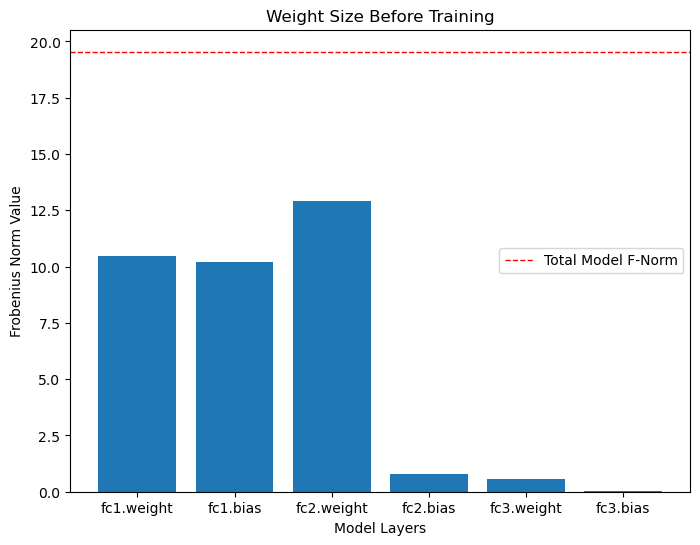

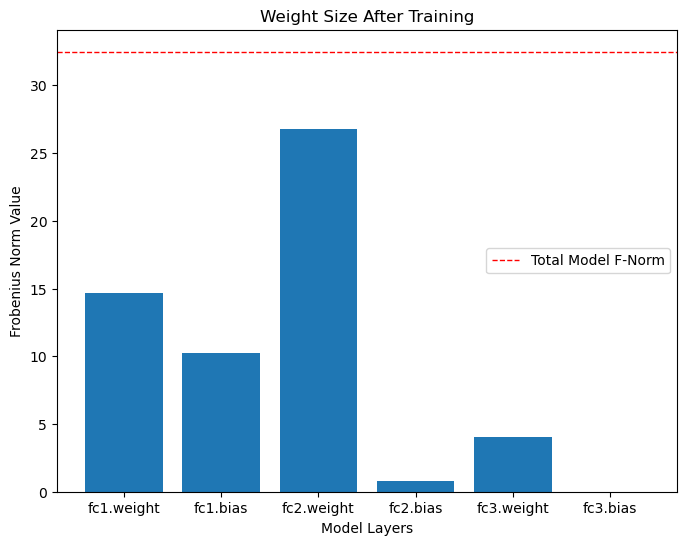

In [25]:
normf, wsf, label = calculate_frobenius_norm(model)

plot_weights(float(normi), label, wsi,
             title='Weight Size Before Training')
plot_weights(float(normf), label, wsf,
             title='Weight Size After Training')

# Early Stopping


Now that we have established that the validation accuracy reaches the peak well before the model overfits, we want to somehow stop the training early. You should have also observed from the above plots that the train/test loss on real data is not very smooth and hence you might guess that the choice of epoch can play a very large role on the val/test accuracy of your model. 

Early stopping stops training when the validation accuracies stop increasing. 

<center><img src="https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/static/early-stopping-machine-learning-5422207.jpg" alt="Overfitting" width="600"/></center>

# L1 and L2 Regularization

L1 (or "LASSO") Regularization uses a penalty which is the sum of the absolute value of all the weights in the DLN, resulting in the following loss function ($L$ is the usual Cross Entropy loss):

\begin{equation}
L_R=L + \lambda \sum \left| w^{(r)}_{ij} \right|
\end{equation}

where $r$ denotes the layer, and $ij$ the specific weight in that layer.

At a high level, L1 Regularization is similar to L2 Regularization since it leads to smaller weights (you will see the analogy in the next subsection). It results in the following weight update equation when using Stochastic Gradient Descent:

\begin{equation}
w^{(r)}_{ij}←w^{(r)}_{ij}−\eta \lambda \text{sgn}\left(w^{(r)}_{ij}\right)−\eta \frac{\partial L}{\partial w_{ij}^{(r)}} 
\end{equation}

where  $\text{sgn}(\cdot)$ is the sign function, such that

\begin{equation}
\text{sgn}(w) = 
\left\{
  \begin{array}{ll}
  +1 & \mbox{if  } w > 0 \\
  -1 & \mbox{if  } w < 0 \\
  0 & \mbox{if  } w = 0
  \end{array}
\right.
\end{equation}

In [43]:
def l1_reg(model):
    """
    Inputs: Pytorch model
    This function calculates the l1 norm of the all the tensors in the model
    """
    l1 = 0.0
    for param in model.parameters():
        l1 += torch.sum(torch.abs(param))

    return l1

set_seed(seed=SEED)
## uncomment to test
net = nn.Linear(20, 20)
print(f"L1 norm of the model: {l1_reg(net)}")

Random seed 2021 has been set.
L1 norm of the model: 48.445133209228516


L2 Regularization, sometimes referred to as “Weight Decay”, is widely used. It works by adding a quadratic penalty term to the Cross Entropy Loss Function $L$, which results in a new Loss Function $L_R$  given by:

\begin{equation}
L_R = L + \lambda \sum \left( w^{(r)}_{ij} \right)^2
\end{equation}

where, again, $r$ denotes the layer, and $ij$ the specific weight in that layer.

In order to get further insight into L2 Regularization, we investigate its effect on the Gradient Descent based update equations for the weight and bias parameters. Taking the derivative on both sides of the above equation, we obtain

\begin{equation}
\frac{\partial L_R}{\partial w^{(r)}_{ij}}=\frac{\partial L}{\partial w^{(r)}_{ij}} + 2\lambda w^{(r)}_{ij}
\end{equation}

Thus the weight update rule becomes:

\begin{equation}
w^{(r)}_{ij}←w^{(r)}_{ij}−η\frac{\partial L}{\partial w^{(r)}_{ij}}−2 \eta \lambda w^{(r)}_{ij}=(1−2 \eta \lambda)w^{(r)}_{ij} − \eta \frac{\partial L}{\partial w^{(r)}_{ij}}
\end{equation}

where, $\eta$ is learning rate.

In [44]:
def l2_reg(model):
    """
    Inputs: Pytorch model
    This function calculates the l2 norm of the all the tensors in the model
    """

    l2 = 0.0
    for param in model.parameters():
        l2 += torch.sum(torch.abs(param)**2)

    return l2

set_seed(SEED)
net = nn.Linear(20, 20)
print(f"L2 norm of the model: {l2_reg(net)}")

Random seed 2021 has been set.
L2 norm of the model: 7.328375339508057


# Dropout

In dropout, we literally drop out (zero out) some neurons during training. Throughout training, on each iteration, standard dropout zeros out some fraction (usually 1/2) of the nodes in each layer before calculating the subsequent layer. Randomly selecting different subsets to dropout introduces noise into the process and reduces overfitting.

<center><img src="https://d2l.ai/_images/dropout2.svg" alt="Dropout" width="600"/></center>


In [45]:
# Network Class - 2D
class NetDropout(nn.Module):
    def __init__(self):
        super(NetDropout, self).__init__()

        self.fc1 = nn.Linear(1, 300)
        self.fc2 = nn.Linear(300, 500)
        self.fc3 = nn.Linear(500, 1)
        # We add two dropout layers
        self.dropout1 = nn.Dropout(0.4)
        self.dropout2 = nn.Dropout(0.2)

    def forward(self, x):
        x = F.leaky_relu(self.dropout1(self.fc1(x)))
        x = F.leaky_relu(self.dropout2(self.fc2(x)))
        output = self.fc3(x)
        return output

In [46]:
set_seed(seed=SEED)
# creating train data
X = torch.rand((10, 1))
X.sort(dim = 0)
Y = 2*X + 2*torch.empty((X.shape[0], 1)).normal_(mean=0, std=1)  # adding small error in the data

X = X.unsqueeze_(1)
Y = Y.unsqueeze_(1)

# creating test dataset
X_test = torch.linspace(0, 1, 40)
X_test = X_test.reshape((40, 1, 1))

# train the network on toy dataset
model = Net()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
max_epochs = 10000
iters = 0

running_predictions = np.empty((40, (int)(max_epochs/500 + 1)))

train_loss = []
test_loss = []
model_norm = []

for epoch in tqdm(range(max_epochs)):

    # training
    model_norm.append(calculate_frobenius_norm(model))
    model.train()
    optimizer.zero_grad()
    predictions = model(X)
    loss = criterion(predictions,Y)
    loss.backward()
    optimizer.step()

    train_loss.append(loss.data)
    model.eval()
    Y_test = model(X_test)
    loss = criterion(Y_test, 2*X_test)
    test_loss.append(loss.data)

    if (epoch % 500 == 0 or epoch == max_epochs - 1):
        running_predictions[:, iters] = Y_test[:, 0, 0].detach().numpy()
        iters += 1

Random seed 2021 has been set.


  0%|          | 0/10000 [00:00<?, ?it/s]

In [48]:
# train the network on toy dataset

# Intialize the model
set_seed(seed=SEED)
model = NetDropout()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
max_epochs = 10000
iters = 0

running_predictions_dp = np.empty((40, (int)(max_epochs / 500)))

train_loss_dp = []
test_loss_dp = []
model_norm_dp = []

for epoch in tqdm(range(max_epochs)):

    # training
    model_norm_dp.append(calculate_frobenius_norm(model))
    model.train()
    optimizer.zero_grad()
    predictions = model(X)
    loss = criterion(predictions, Y)
    loss.backward()
    optimizer.step()

    train_loss_dp.append(loss.data)
    model.eval()
    Y_test = model(X_test)
    loss = criterion(Y_test, 2*X_test)
    test_loss_dp.append(loss.data)

    if (epoch % 500 == 0 or epoch == max_epochs):
        running_predictions_dp[:, iters] = Y_test[:, 0, 0].detach().numpy()
        iters += 1

Random seed 2021 has been set.


  0%|          | 0/10000 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

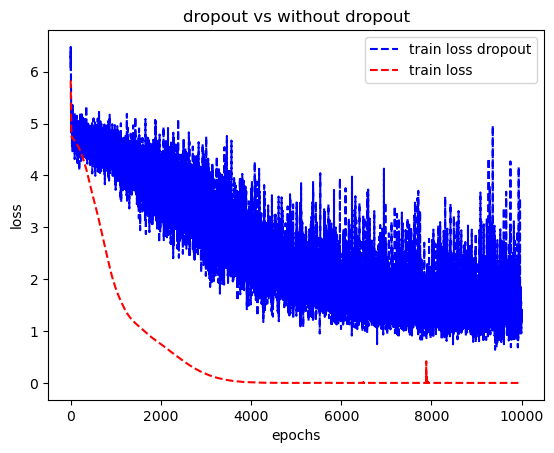

In [49]:
plt.figure()
plt.plot(train_loss_dp, label='train loss dropout', c='blue', ls='dashed')
plt.plot(train_loss, label='train loss', c='red', ls='dashed')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.title('dropout vs without dropout')
plt.legend()
plt.show()

# Data Augmentation

Data augmentation is often used to increase the number of training samples. Now we will explore the effects of data augmentation on regularization. Here regularization is achieved by adding noise into training data after every epoch.

Pytorch's torchvision module provides a few built-in data augmentation techniques, which we can use on image datasets. Some of the techniques we most frequently use are:


*   Random Crop
*   Random Rotate
*   Vertical Flip
*   Horizontal Flip



# Hyperparameter Tuning



Hyper-Parameter tuning is often difficult and time consuming.  It is a key part of training any Deep Learning model to give good generalization. There are a few techniques that we can use to guide us during the search. 



*   Grid Search: Try all possible combinations of hyperparameters
*   Random Search: Randomly try different combinations of hyperparameters
*   Coordinate-wise Gradient Descent: Start at one set of hyperparameters and try changing one at a time, accept any changes that reduce your validation error
*   Bayesian Optimization/ Auto ML:  Start from a set of hyperparameters that have worked well on a similar problem, and then do some sort of local exploration (e.g., gradient descent) from there.

There are lots of choices, like what range to explore over, which parameter to optimize first, etc. Some hyperparameters don’t matter much (people use a dropout of either 0.5 or 0, but not much else).  Others can matter a lot more (e.g., size and depth of the neural net). The key is to see what worked on similar problems.

One can automate the process of tuning the network Architecture using "Neural Architecture Search", which designs new architectures using a few building blocks (Linear, Convolutional, Convolution Layers, etc.) and optimizes the design based on performance using a wide range of techniques such as Grid Search, Reinforcement Learning, GD, Evolutionary Algorithms, etc. This obviously requires very high computer power. Read this [article](https://lilianweng.github.io/lil-log/2020/08/06/neural-architecture-search.html) to learn more about NAS.    
